---
title: "Analysis of Time-series Data"
format:
    html:
        toc: true
        highlight-style: ayu
---

https://climateknowledgeportal.worldbank.org/country/peru/climate-data-historical

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn import linear_model
import statsmodels.api as sm

In [13]:
temp_df = pd.read_csv("observed-annual-average-mean-surface-air-temperature-of-junín,-peru-for-1901-2022.csv", sep=",")
temp_df = temp_df.rename(columns={"Category":"Year", "Annual Mean":"Temp_annual_mean"}).drop(columns=["5-yr smooth"])


prec_df = pd.read_csv("observed-annual-precipitation-of-junín,-peru-for-1901-2022.csv", sep=",")
prec_df = prec_df.rename(columns={"Category":"Year", "Annual Mean":"Prec_annual_mean"}).drop(columns=["5-yr smooth"])

climate_df = pd.merge(temp_df, prec_df, on="Year", how="left")
climate_df

,Year,Temp_annual_mean,Prec_annual_mean
0,1901,14.17,1273.85
1,1902,14.16,1273.85
2,1903,13.85,1273.85
3,1904,13.70,1273.85
4,1905,14.07,1273.85
...,...,...,...
117,2018,14.65,1273.85
118,2019,14.84,1262.93
119,2020,15.00,1273.85
120,2021,14.97,1046.47


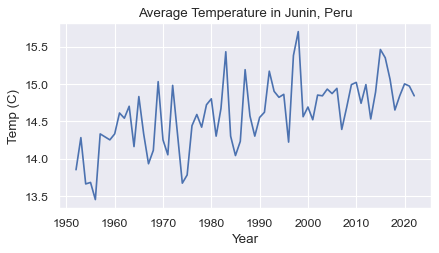

,Year,Temp_annual_mean,Prec_annual_mean
51,1952,13.85,1287.30
52,1953,14.28,1345.91
53,1954,13.66,1328.92
54,1955,13.68,1008.42
55,1956,13.45,1080.09


In [38]:
plt.figure(figsize=(6, 3), dpi=80)
subset = climate_df[climate_df.Year > 1951] 

sns.lineplot(data=subset, x="Year", y="Temp_annual_mean")
plt.title("Average Temperature in Junin, Peru")
plt.ylabel('Temp (C)')
plt.show()
subset.head()

[[0.01389604]]


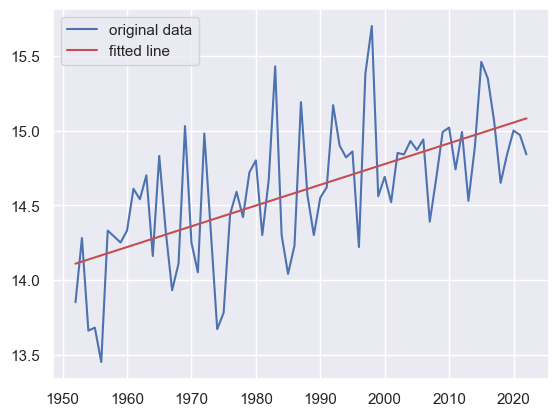

In [25]:
clf = linear_model.LinearRegression()
x,y = subset.Year.values.reshape(-1,1) , subset.Temp_annual_mean.values.reshape(-1,1)

clf.fit(x, y)
print(clf.coef_) # Print the beta values found via regression 
y_hat = clf.predict(x)
plt.plot(x, y, label='original data')
plt.plot(x, y_hat, 'r', label='fitted line')
plt.legend()

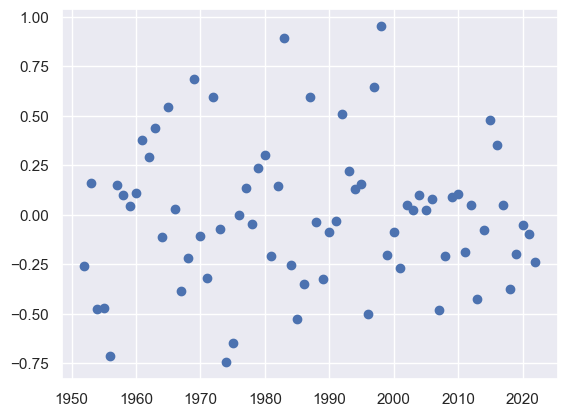

In [26]:
linear_residuals = y - y_hat
plt.plot(x, linear_residuals,'o')

<Axes: >

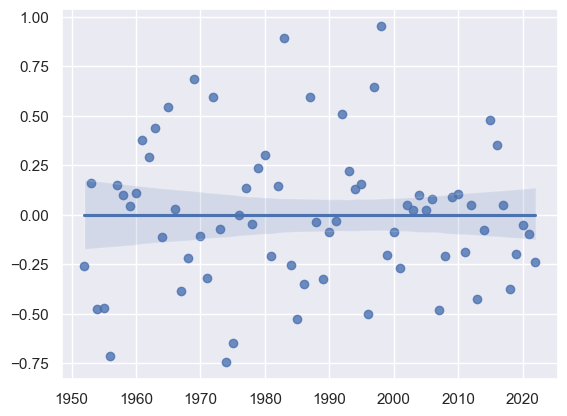

In [29]:
sns.regplot(x=x, y=linear_residuals)

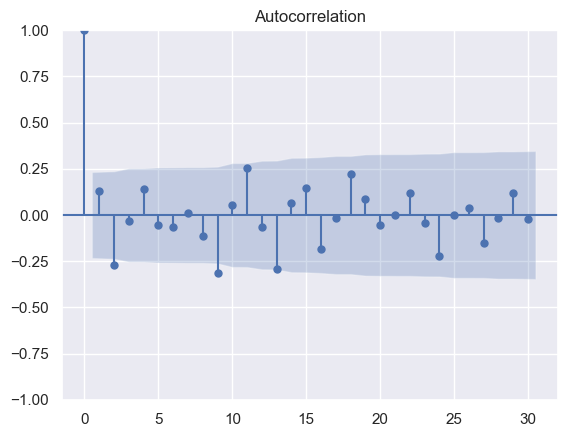

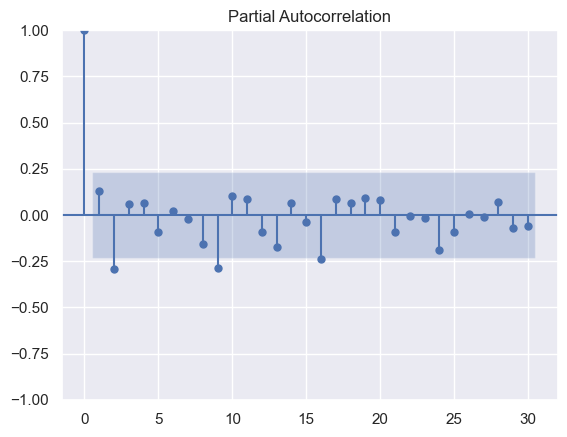

In [31]:
sm.graphics.tsa.plot_acf(linear_residuals, lags=30)
plt.show()
sm.graphics.tsa.plot_pacf(linear_residuals, lags=30)
plt.show()

